In [1]:
%pip install "openvino-dev>=2023.1.0"
%pip install gradio



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov

sys.path.append("../utils")
import notebook_utils as utils

import shutil
from pathlib import Path
from IPython.core.display import HTML


## Configurations
[back to top ⬆️](#Table-of-contents:)

* `PRECISION` - {FP16, FP32}, default: FP16.
* `MODEL_DIR` - directory where the model is to be stored, default: public.
* `MODEL_NAME` - name of the model used for inference, default: colorization-v2.
* `DATA_DIR` - directory where test images are stored, default: data.

In [3]:
PRECISION = "FP16"
MODEL_DIR = "models"
MODEL_NAME = "colorization-v2"
MODEL_PATH = f"{MODEL_DIR}/public/{MODEL_NAME}/{PRECISION}/{MODEL_NAME}.xml"
DATA_DIR = "data"

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [4]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

## Download the model
[back to top ⬆️](#Table-of-contents:)

`omz_downloader` downloads model files from online sources and, if necessary, patches them to make them more usable with Model Converter.

In this case, `omz_downloader` downloads the checkpoint and pytorch model of [colorization-v2](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/colorization-v2/README.md) or [colorization-siggraph](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/colorization-siggraph) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/index.md) and saves it under `MODEL_DIR`, as specified in the configuration above.

In [5]:
download_command = (
    f"omz_downloader "
    f"--name {MODEL_NAME} "
    f"--output_dir {MODEL_DIR} "
    f"--cache_dir {MODEL_DIR}"
)
! $download_command

################|| Downloading colorization-v2 ||################

========== Retrieving models\public\colorization-v2\ckpt\colorization-v2-eccv16.pth from the cache

========== Retrieving models\public\colorization-v2\model\__init__.py from the cache

========== Retrieving models\public\colorization-v2\model\base_color.py from the cache

========== Retrieving models\public\colorization-v2\model\eccv16.py from the cache

========== Replacing text in models\public\colorization-v2\model\__init__.py
========== Replacing text in models\public\colorization-v2\model\__init__.py
========== Replacing text in models\public\colorization-v2\model\eccv16.py



## Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

`omz_converter` converts the models that are not in the OpenVINO™ IR format into that format using model conversion API.

The downloaded pytorch model is not in OpenVINO IR format which is required for inference with OpenVINO runtime. `omz_converter` is used to convert the downloaded pytorch model into ONNX and OpenVINO IR format respectively

In [6]:
if not os.path.exists(MODEL_PATH):
    convert_command = (
        f"omz_converter "
        f"--name {MODEL_NAME} "
        f"--download_dir {MODEL_DIR} "
        f"--precisions {PRECISION}"
    )
    ! $convert_command

## Loading the Model
[back to top ⬆️](#Table-of-contents:)

Load the model in OpenVINO Runtime with `ie.read_model` and compile it for the specified device with `ie.compile_model`.

In [7]:
core = ov.Core()
model = core.read_model(model=MODEL_PATH)
compiled_model = core.compile_model(model=model, device_name=device.value)
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)
N, C, H, W = list(input_layer.shape)

## Utility Functions
[back to top ⬆️](#Table-of-contents:)


In [8]:
def read_image(impath: str) -> np.ndarray:
    

    raw_image = cv2.imread(impath)
    if raw_image.shape[2] > 1:
        image = cv2.cvtColor(
            cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB
        )
    else:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    return image


def plot_image(image: np.ndarray, title: str = "") -> None:
    

    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()


def plot_output(gray_img: np.ndarray, color_img: np.ndarray) -> None:
    

    fig = plt.figure(figsize=(12, 12))

    ax1 = fig.add_subplot(1, 2, 1)
    plt.title("Input", fontsize=20)
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    plt.title("Colorized", fontsize=20)
    ax2.axis("off")

    ax1.imshow(gray_img)
    ax2.imshow(color_img)

    plt.show()

## Load the Image
[back to top ⬆️](#Table-of-contents:)


In [9]:
local_img_path_3 = "C:\\Users\\anmol\\OneDrive\\Documents\\Korean Exchange 2024\\KimChi\\BackEnd\\222-vision-image-colorization\\data\\Editted.jpg"
local_img_path_4 = "C:\\Users\\anmol\\OneDrive\\Documents\\Korean Exchange 2024\\KimChi\\BackEnd\\222-vision-image-colorization\\data\\Editted 2.jpg"




shutil.copy(local_img_path_3, "data/test_3.jpg")
shutil.copy(local_img_path_4, "data/test_4.jpg")



test_img_3 = read_image("data/test_3.jpg")
test_img_4 = read_image("data/test_4.jpg")



In [10]:
def colorize(gray_img: np.ndarray, model, output_layer, target_size=(W, H)) -> np.ndarray:
    """
    Colorize a grayscale image using a specified model.

    Parameters:
        gray_img (ndarray): Numpy array representing the original grayscale image.
        model: The colorization model.
        output_layer: The output layer of the colorization model.
        target_size (tuple): Target size for resizing the image.

    Returns:
        colorized_image (ndarray): Numpy array depicting the colorized version of the original image.
    """
    # Check if the input image is already in color format
    if gray_img.shape[2] == 3:
        img_rgb = gray_img.astype(np.float32) / 255
    else:
        img_rgb = cv2.cvtColor(gray_img.astype(np.float32) / 255, cv2.COLOR_GRAY2RGB)

    # Continue with the rest of the processing
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
    img_l_rs = cv2.resize(img_lab[:, :, 0], target_size)

    # Inference
    inputs = np.expand_dims(img_l_rs, axis=(0, 1))
    res = model([inputs])[output_layer]
    update_res = np.squeeze(res)

    # Post-process
    out = update_res.transpose((1, 2, 0))
    out = cv2.resize(out, (gray_img.shape[1], gray_img.shape[0]))
    img_lab_out = np.concatenate((img_lab[:, :, 0][:, :, np.newaxis], out), axis=2)
    img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2RGB), 0, 1)
    colorized_image = (cv2.resize(img_bgr_out, (gray_img.shape[1], gray_img.shape[0])) * 255).astype(np.uint8)

    return colorized_image




In [11]:

color_img_3 = colorize(test_img_3, compiled_model, output_layer)
color_img_4 = colorize(test_img_4, compiled_model, output_layer)

## Display Colorized Image
[back to top ⬆️](#Table-of-contents:)


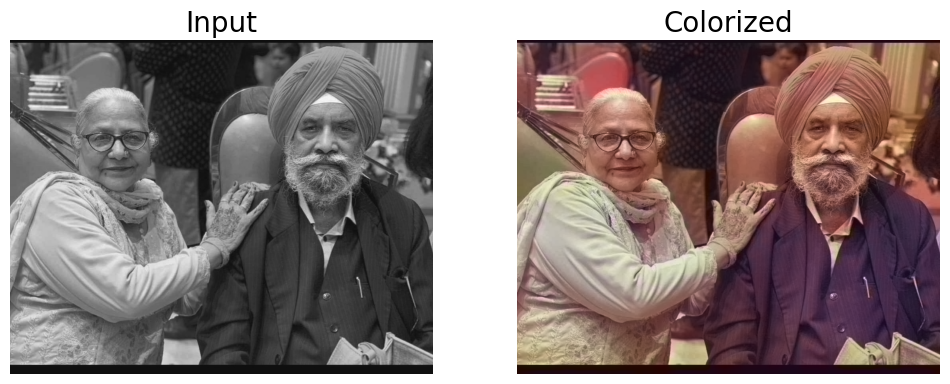

In [12]:
plot_output(test_img_3, color_img_3)

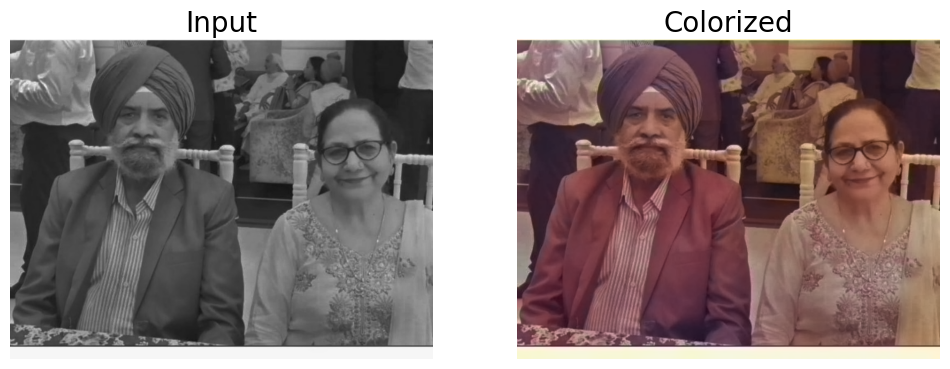

In [13]:
plot_output(test_img_4, color_img_4)

In [14]:
import gradio as gr
from PIL import Image

def colorize_image(input_image):
    # Convert Gradio Image to numpy array
    input_np = np.array(input_image)

    # Perform colorization using your model (use the colorize function)
    colorized_img = colorize(input_np, compiled_model, output_layer)

    # Convert the result back to Gradio-compatible format (PIL Image)
    result_pil = Image.fromarray(colorized_img)

    return result_pil

# Create Gradio Interface
iface = gr.Interface(
    fn=colorize_image,
    inputs=gr.Image(),
    outputs=gr.Image(),
    live=True,
    title="Gray-Scale to Colored[회색조에서 컬러로]",
    description="Click image icon, select image, AI converts to color, download result.[이미지 아이콘을 클릭하고 이미지를 선택하면 AI가 색상으로 변환하고 결과를 다운로드합니다.]",
    theme="gradio/monochrome"
)

# Deploy the Gradio interface as a web app
iface.launch(share=True)


Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/02/09 10:01:42 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout
